# Building Stellar Populations

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtificialStellarPopulations/ArtPop/blob/main/colab_tutorials/pops.ipynb)

In this tutorial, we demonstrate **ArtPop**’s built-in stellar population synthesis capability. Because of the modular design of the code, it is possible to build stellar populations independently from generating mock images. This is useful, for example, when you are only interested in calculating integrated photometric properties of the population. 

**Note:** To generate MIST synthetic photometry using **ArtPop**, [MIST isochrone grids](../getting_started/mist.rst) are required. The first time you use a MIST grid, **ArtPop** will download it and save it to your `MIST_PATH`. If this environment variable is not set, the grid(s) will be saved in `~/.artpop/mist`.

In [1]:
# Third-party imports 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u   

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(112)

## Simple Stellar Population (SSP)

In **ArtPop**, the basic stellar population unit is the simple stellar population (SSP), which is a population of stars of a single age and metallicity. To synthesize an SSP, **ArtPop** samples stellar masses from a user-specified initial mass function (``imf``) and generates stellar magnitudes by interpolating synthetic photometry from an isochrone model.

Here, we will use the MIST isochrone models using **ArtPop**'s built-in tools for fetching MIST synthetic photometry grids. To generate an SSP using MIST, we use the ``MISTSSP`` class:

In [2]:
ssp = artpop.MISTSSP(
    log_age = 9,          # log of age in years
    feh = -1,             # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s)
    num_stars = 1e5,      # number of stars
    imf = 'kroupa',       # default imf
    random_state = rng,   # random state for reproducibility
)

This generates a population of 10$^5$ stars of age 1 Gyr and metallicity [Fe/H] = -1 (a tenth the solar value). With ``phot_system = 'LSST'``, stellar magnitudes in the LSST _ugrizy_ photometric system are interpolated and stored in the ``ssp`` object. It is also possible to pass a list of photometric systems, e.g. ``['LSST', 'SDSSugriz']``, in which case magnitudes in both systems are interpolated and stored.

For reference, the supported MIST photometric system names are stored in the variable ``phot_system_list``: 

In [3]:
artpop.phot_system_list

['HST_WFC3',
 'HST_ACSWF',
 'SDSSugriz',
 'CFHTugriz',
 'DECam',
 'HSC',
 'JWST',
 'LSST',
 'UBVRIplus',
 'UKIDSS',
 'WFIRST']

The filter names for a given photometric system may be recovered using the ``get_filter_names`` function:

In [4]:
artpop.get_filter_names('LSST')

['LSST_u', 'LSST_g', 'LSST_r', 'LSST_i', 'LSST_z', 'LSST_y']

Using the ``log_Teff`` and ``log_L`` attributes of ``ssp``, the HR-diagram for the population may be plotted like this:

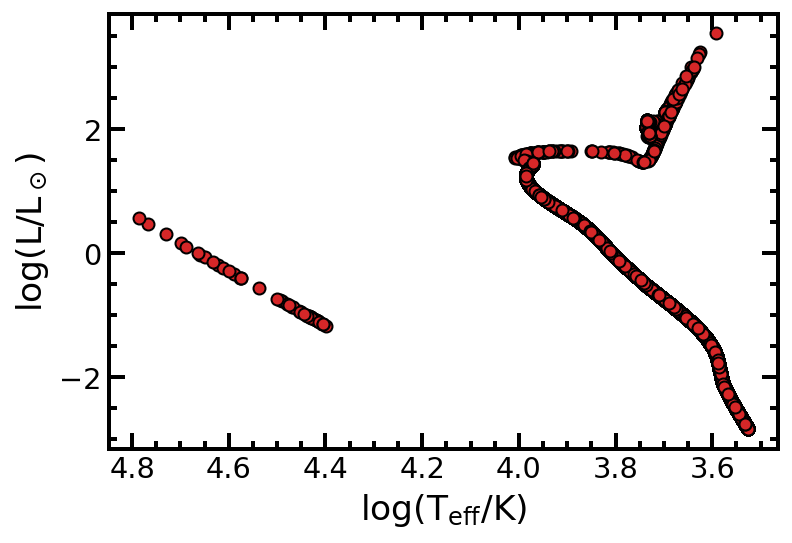

In [5]:
plt.plot(ssp.log_Teff, ssp.log_L, 'o', c='tab:red', mec='k')
plt.gca().invert_xaxis()
plt.minorticks_on()
plt.xlabel(r'$\log(\mathrm{T_{eff}/K})$')
plt.ylabel(r'$\log(\mathrm{L/L_\odot})$');

### Integrated Properties

There are several methods for calculating integrated photometric properties of the population:

In [6]:
print(f"M_i   = {ssp.total_mag('LSST_i'): .2f}")
print(f"SBF_i = {ssp.sbf_mag('LSST_i'): .2f}")
print(f"g - i = {ssp.integrated_color('LSST_g', 'LSST_i'): .2f}")

M_i   = -8.23
SBF_i = -1.53
g - i =  0.40


Note the returned magnitudes are in absolute units. This is because by default the SSP is assumed to be at 10 pc. To change the distance, you can either pass ``distance`` as an argument when you initialize ``SSP``, or you can use the ``set_distance`` method:  

In [7]:
# the distance can be given as a float or an astropy unit
distance = 10 * u.kpc 
ssp.set_distance(distance)
print(f'D = {distance:.0f}\n--------------')
print(f"m_i   = {ssp.total_mag('LSST_i'): .2f}")
print(f"sbf_i = {ssp.sbf_mag('LSST_i'): .2f}")
print(f"g - i = {ssp.integrated_color('LSST_g', 'LSST_i'): .2f}")


# if a float is given, the unit is assumed to be Mpc
distance = 10
ssp.set_distance(distance)
print(f'\nD = {distance} Mpc\n--------------')
print(f"m_i   = {ssp.total_mag('LSST_i'): .2f}")
print(f"sbf_i = {ssp.sbf_mag('LSST_i'): .2f}")
print(f"g - i = {ssp.integrated_color('LSST_g', 'LSST_i'): .2f}")

D = 10 kpc
--------------
m_i   =  6.77
sbf_i =  13.47
g - i =  0.40

D = 10 Mpc
--------------
m_i   =  21.77
sbf_i =  28.47
g - i =  0.40


In [8]:
# the distance and distance modulus are attributes
print(f'D = {ssp.distance}, m - M = {ssp.dist_mod}')

D = 10.0 Mpc, m - M = 30.0


### Phase Masks

When using MIST SSPs, **ArtPop** uses the [Primary Equivalent Evolutionary Points (EEPs)](https://ui.adsabs.harvard.edu/abs/2016ApJS..222....8D/abstract) to identify the phase of stellar evolution of each star in the population. Use the ``select_phase`` method to generate a boolean mask that is set to ``True`` for stars in the given phase. 

In [9]:
# available phases
ssp.phases

['PMS',
 'MS',
 'giants',
 'RGB',
 'CHeB',
 'AGB',
 'EAGB',
 'TPAGB',
 'postAGB',
 'WDCS']

Let's plot the HR-diagram with different colors for the main sequence (MS), red giant branch (RGB), and asymptotic giant branch (note that here the subgiant branch is included in the RGB):

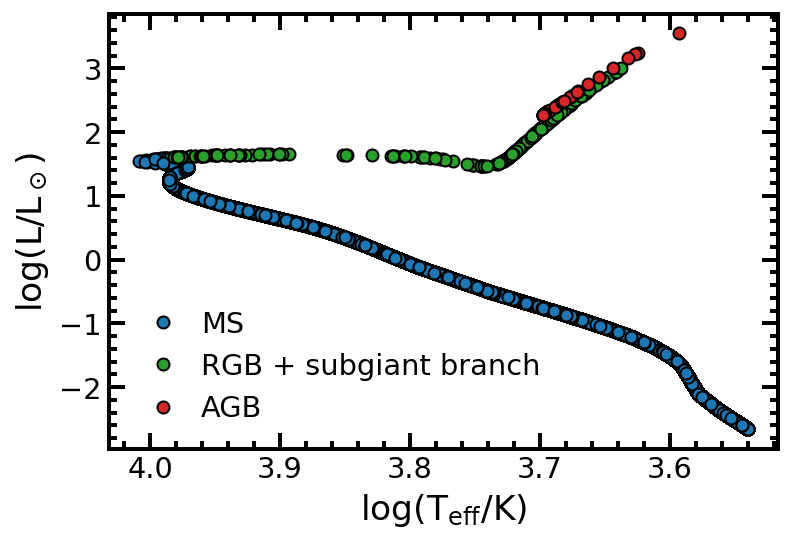

In [10]:
# generate boolean phase masks
MS = ssp.select_phase('MS')
RGB = ssp.select_phase('RGB')
AGB = ssp.select_phase('AGB')

plt.plot(ssp.log_Teff[MS], ssp.log_L[MS], 'o', 
         label='MS', c='tab:blue', mec='k')
plt.plot(ssp.log_Teff[RGB], ssp.log_L[RGB], 'o', 
         label='RGB + subgiant branch', 
         c='tab:green', mec='k')
plt.plot(ssp.log_Teff[AGB], ssp.log_L[AGB], 'o', 
         label='AGB', c='tab:red', mec='k')

plt.legend(loc='lower left')
plt.gca().invert_xaxis()
plt.minorticks_on()
plt.xlabel(r'$\log(\mathrm{T_{eff}/K})$')
plt.ylabel(r'$\log(\mathrm{L/L_\odot})$');

Check out the [SSP](../api/artpop.stars.SSP.rst) API (or use tab complete) to see the full list of attributes and methods that are available.

### Sampling an IMF

As noted above, **ArtPop** is modular, which means all of its components can be used independently. For example, here we sample stellar masses from the [Kroupa initial mass function](https://ui.adsabs.harvard.edu/abs/2001MNRAS.322..231K/abstract):

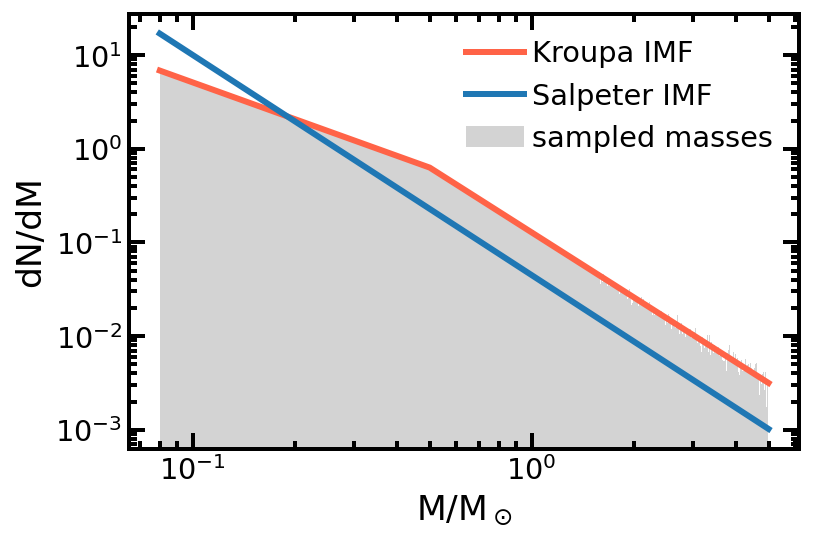

In [11]:
# sample the Kroupa IMF
m_min = 0.08 # minimum mass
m_max = 5.0  # maximum mass
sampled_masses = artpop.sample_imf(1e6, imf='kroupa', 
                                   m_min=m_min, m_max=m_max, 
                                   random_state=rng)

# plot histogram of sampled masses
plt.hist(sampled_masses, bins='auto', color='lightgray', 
         density=True, label='sampled masses')

# plot the analytic Kroupa and Salpeter IMFs for comparison
mass_grid = np.logspace(np.log10(m_min), np.log10(m_max), 1000)
plt.loglog(mass_grid, artpop.kroupa(mass_grid, norm_type='number'), 
           c='tomato', lw=3, label='Kroupa IMF')
plt.loglog(mass_grid, artpop.salpeter(mass_grid, norm_type='number'), 
           c='tab:blue', lw=3, label='Salpeter IMF')

plt.legend()
plt.xlabel('M/M$_\odot$')
plt.ylabel('dN/dM');

## Composite Stellar Populations

In **ArtPop**, building composite stellar populations (CSPs) composed of two or more SSPs is as simple adding together ``SSP`` objects. In this example, we'll create three SSPs $-$ an old, intermediate-age, and young population, which we will combine into a composite population.

In [12]:
ssp_old = artpop.MISTSSP(
    log_age = 10.1,       # log of age in years
    feh = -1.5,           # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s)
    num_stars = 5e5,      # number of stars
    random_state = rng,   # random state for reproducibility
)

ssp_intermediate = artpop.MISTSSP(
    log_age = 9.5,        # log of age in years
    feh = -1,             # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s)
    num_stars = 1e5,      # number of stars
    random_state = rng,   # random state for reproducibility
)

ssp_young = artpop.MISTSSP(
    log_age = 8.5,        # log of age in years
    feh = 0,              # metallicity [Fe/H]
    phot_system = 'LSST', # photometric system(s)
    num_stars = 1e4,      # number of stars
    random_state = rng,   # random state for reproducibility
)

We then intuitively combine the SSPs using the `+` operator:

In [13]:
csp = ssp_old + ssp_intermediate + ssp_young
print(type(csp))

<class 'artpop.stars.populations.CompositePopulation'>


All of the ``SSP`` attributes and methods are available to `CSP` objects. Let's use the `star_mags` method to plot a color magnitude diagram for the CSP:

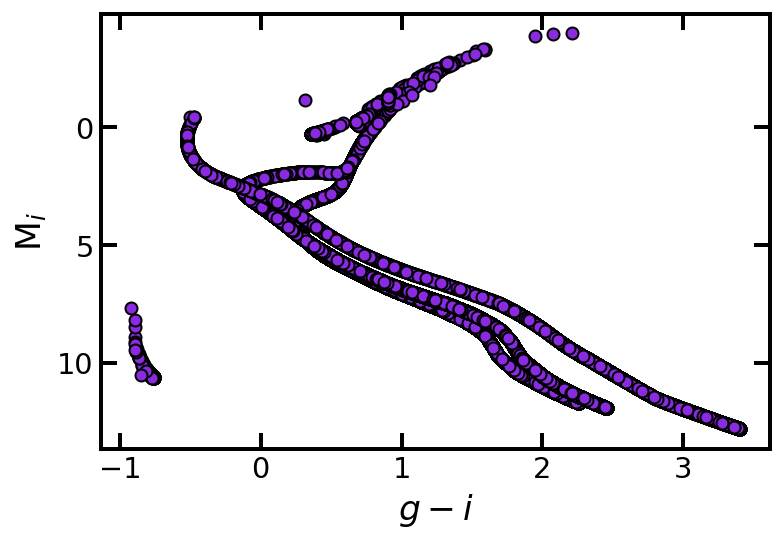

In [14]:
i = csp.star_mags('LSST_i')
g = csp.star_mags('LSST_g')
plt.plot(g-i, i, 'o', c='blueviolet', mec='k')
plt.gca().invert_yaxis()

plt.xlabel(r'$g-i$')
plt.ylabel(r'M$_i$');

Each SSP is labeled (1, 2, 3, etc.) from left to right in the ``csp`` definition. You can isolate each population like this:

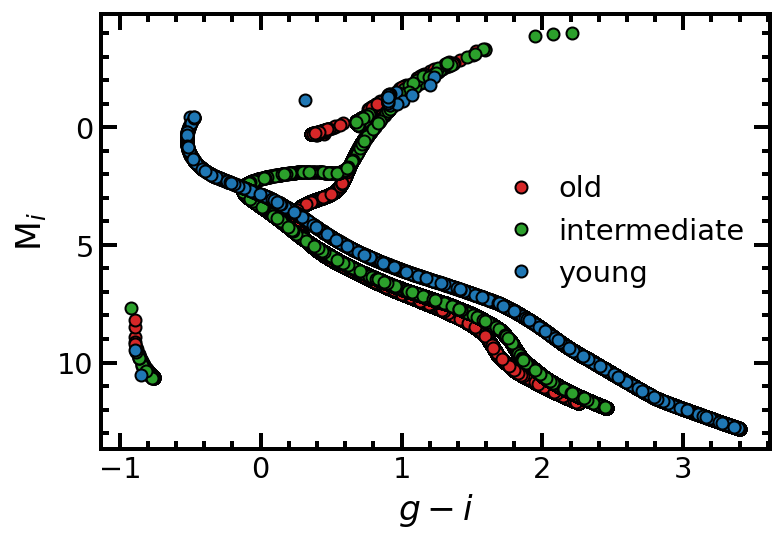

In [15]:
old = csp.ssp_labels == 1
med = csp.ssp_labels == 2
young = csp.ssp_labels == 3

plt.plot(g[old] - i[old], i[old], 'o', 
         c='tab:red', mec='k', label='old')
plt.plot(g[med] - i[med], i[med], 'o', 
         c='tab:green', mec='k', label='intermediate')
plt.plot(g[young] - i[young], i[young], 'o', 
         c='tab:blue', mec='k', label='young')

plt.legend(loc='center right')
plt.minorticks_on()
plt.gca().invert_yaxis()
plt.xlabel(r'$g-i$')
plt.ylabel(r'M$_i$');